In [ ]:
!pip install -U sentence-transformers
!pip install umap-learn
!pip install scikit-learn-extra
!pip install coclust

In [34]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
def load_data():
    ng20 = fetch_20newsgroups(subset='test')
    corpus = ng20.data[:2000]
    labels = ng20.target[:2000]
    df_labels = pd.DataFrame(labels)
    df_labels.rename(columns = {0:'label'}, inplace = True)
    df_corpus = pd.DataFrame(corpus)
    df_corpus.rename(columns = {0:'text'}, inplace = True)
    return df_corpus, df_labels

In [10]:
df_corpus, df_labels = load_data()

# Pré-traitement des données textuelles

On enchaîne dans la fonction data_preprocessing les méthodes de nettoyage classiques.
* Suppression des tag HTML
* Conservation des mots uniquement
* Passage en minuscule
* Suppression des mots vides
* Tokenization
* Lemmatisation
* Réassemblage des articles

In [12]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') # définir les stop_words
lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):

  # nettoyage des données
  article = re.sub(re.compile('<.*?>'), '', review) #removing html tags
  article =  re.sub('[^A-Za-z0-9]+', ' ', review) #taking only words

  # miniscule
  article = article.lower()

  # tokenization
  tokens = nltk.word_tokenize(article) # converts articles to tokens

  # stop_words removal
  article = [word for word in tokens if word not in stop_words] #removing stop words

  # lemmatization
  article = [lemmatizer.lemmatize(word) for word in article]

  # join words in preprocessed review
  article = ' '.join(article)

  return article

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
# On applique le pré-traitement à nos données df_corpus
df_corpus['preprocessed_text'] = df_corpus['text'].apply(lambda article: data_preprocessing(article))
df_corpus

,text,preprocessed_text
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,v064mb9k ubvmsd cc buffalo edu neil b gandler ...
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,rick miller rick ee uwm edu subject x face org...
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,mathew mathew mantis co uk subject strong weak...
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,bakken c arizona edu dave bakken subject saudi...
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,livesey solntze wpd sgi com jon livesey subjec...
...,...,...
1995,Organization: Queen's University at Kingston\n...,organization queen university kingston leek qu...
1996,From: stevek@cellar.org (Steve Kraisler)\nSubj...,stevek cellar org steve kraisler subject atf b...
1997,From: pmetzger@snark.shearson.com (Perry E. Me...,pmetzger snark shearson com perry e metzger su...
1998,From: d89-mad@ludd.luth.se (Mattias ]slund)\nS...,d89 mad ludd luth se mattias slund subject rem...


In [16]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [17]:
embeddings = model.encode(df_corpus['preprocessed_text'])

In [18]:
embeddings.shape

(2000, 384)

In [37]:
# Define the number of components to keep

def PCA_method(data, n_comp):

    # Initialize PCA object
    pca = PCA(n_components=n_comp)

    # Fit PCA on embeddings
    pca.fit(data)

    # Apply dimensionality reduction
    df_pca = pd.DataFrame(pca.transform(data))

    # Add label column to the new dataframe
    df_pca['label'] = df_labels

    # Rename columns
    df_pca.columns = ['PC'+str(i+1) for i in range(n_comp)] + ['label']

    return df_pca

In [36]:
df_pca = PCA_method(embeddings, 20)
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,label
0,-0.442556,0.063776,-0.408671,0.296683,-0.535789,0.414540,0.586858,0.080657,0.531327,-0.409535,...,-0.695614,0.276895,-0.135220,-0.044485,0.362100,0.311406,0.253753,1.085441,0.151051,7
1,-0.383447,-0.217873,-0.311945,0.247777,0.664634,-0.086360,-0.354765,-0.245262,-0.385597,-0.592525,...,-0.358676,-0.265126,-0.816443,0.018915,-0.842256,0.316716,-0.206900,0.075384,-0.066510,5
2,2.094075,-0.615010,-0.599731,-0.903770,-0.759492,-0.115670,0.269028,0.303378,0.067605,-0.017940,...,0.223396,-0.840364,0.488766,0.022182,-0.009621,-0.706397,-0.015261,-0.132014,0.184720,0
3,2.021340,-0.566834,0.196775,0.373841,0.092070,-0.330148,-0.842277,-0.309049,-0.086228,0.498655,...,-0.425368,-0.112079,0.093741,-0.807158,0.143529,0.380211,-0.313786,-0.133280,0.319749,17
4,1.835386,-0.183075,-0.663000,-0.307043,-0.390860,-1.270785,0.247919,-0.017293,-0.428514,-0.233618,...,0.352631,0.126364,-0.253454,-0.066112,-0.746024,-0.323647,-0.391810,-0.003859,0.176002,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.902262,-0.164176,-0.275304,-0.482388,0.189850,-0.849317,-0.315231,-0.180266,0.778630,-0.406645,...,-0.859451,-0.212082,-0.447165,0.260060,-0.269839,0.335967,-0.079112,0.476074,-0.035284,12
1996,0.796921,0.493582,0.945602,0.029751,0.445440,1.203424,0.876272,0.317756,-0.681974,-0.196640,...,-0.187555,0.387451,-1.236932,-1.014758,0.603153,-0.233718,-0.279592,-0.212683,-0.275041,16
1997,-0.568841,0.206254,0.930503,-0.312253,0.439266,0.718485,-0.106674,-0.083449,-0.884947,0.089818,...,0.915990,-0.585764,0.502793,0.264143,-0.326976,0.225945,-0.023365,0.033475,0.205536,11
1998,-0.351285,-0.772019,-0.311087,-0.515172,0.476667,-0.063696,-1.068853,0.385120,0.167516,0.379725,...,0.039694,-0.127389,0.338631,0.272095,-0.575014,-0.232449,0.096279,-0.042917,0.259307,2


In [38]:
def plot_elbow(n_range, data):
    # Try different values of k
    k_values = range(1, n_range)
    inertia_values = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(k_values, inertia_values, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

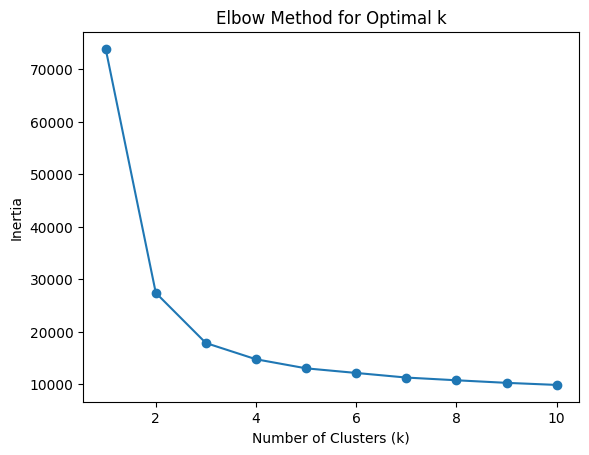

In [39]:
plot_elbow(11, df_pca.iloc[:-1])

In [40]:
def plot_clusters(num_clusters):
    # Créer l'objet KMeans avec l'initialisation K-means++
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Initialize LabelEncoder object
    le = LabelEncoder()

    # Fit and transform the label column to numerical values
    df_pca['label'] = le.fit_transform(df_pca['label'])

    # Plot scatter plot
    plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['label'], cmap='viridis')
    plt.colorbar()
    plt.show()

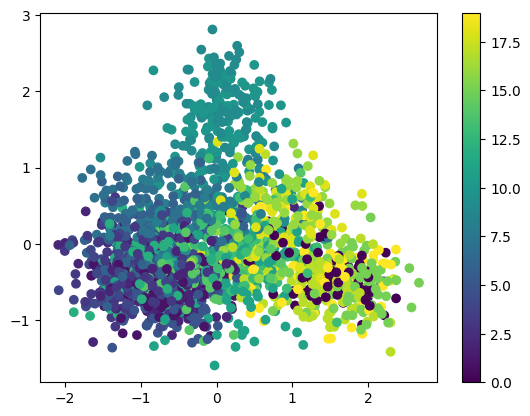

In [41]:
plot_clusters(3)

In [42]:
def kmeans_method(data, labels,  num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    kmeans.fit(data)
    kmeans_labels = kmeans.labels_
    nmi_kpp_pca = normalized_mutual_info_score(labels, kmeans_labels )
    ari_kpp_pca = adjusted_rand_score(labels, kmeans_labels)
    return nmi_kpp_pca, ari_kpp_pca

In [43]:
nmi_kpp_pca, ari_kpp_pca = kmeans_method(df_pca.iloc[:,:-1], df_labels['label'],  3)
print("NMI pour kmeans++ avec la PCA:", nmi_kpp_pca)
print("ARI pour kmeans++ avec la PCA :", ari_kpp_pca)

NMI pour kmeans++ avec la PCA: 0.3358928789400297
ARI pour kmeans++ avec la PCA : 0.09759522185439681


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
